# Building an AI surrogate model for a directional coupler

**Note: the cost of running the entire notebook is higher than 2 FlexCredits. It also requires at least tidy3d version 2.8 to run. To run the notebook, you will need pytorch installed ([pytorch information](https://pytorch.org)). The notebook has been tested with pytorch version 2.5.1.**

In this notebook, we build a machine learning model of a directional coupler (DC) that splits power from an incoming waveguide into two output waveguides. Using the surrogate model, we design a DC with a 75/25 splitting ratio. This coupling optimization boils down to choosing the gap size `wg_spacing_coup` and coupling length `coup_length` of the DC.

Through the machine learning training process, we demonstrate how tidy3d can be used as a data source when training AI models for electromagnetics. We first run a batch of simulations with tidy3d where the two geometric parameters are randomly sampled for each simulation. A mode is injected into one waveguide and monitors on both waveguides characterize the final power split between the two outputs. From this, we define a fitness function describing the performance of a given directional coupler. We define the fitness as the mean squared error between desired output power in each waveguide and actual power. The desired output power fractions are 0.25 and 0.75 in the top and bottom waveguides, respectively. By plotting the fitness function, we can observe that we have found a variety of suitable solutions to the coupling problem. We have also collected a significant amount of data that can be used as input to a data driven model of the coupling. We use the broadband simulation data collected in the first step to train a fully connected neural network. The network is optimized to learn the mapping between the waveguide spacing, coupling length, and input frequency to the power fraction in the two output waveguides. We refer to this network as a surrogate solver because we can now use it as an approximate substitute for the full electromagnetic simulation. The final step of the optimization uses this surrogate solver inside of a Bayesian optimization routine to identify a more optimal set of parameters for the directional coupler. With this set of parameters, we can use tidy3d to run a final verification of the design and evaluate the fidelity of the surrogate solver when compared to ground truth simulation results. The general flow of the notebook is shown in the diagram below.

 <center><img src="img/directional_coupler_surrogate.svg" alt="diagram" width="700"/></center>

In [1]:
# Standard python and external package imports
import pickle
from pathlib import Path

import gdstk
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

# tidy3D imports
import tidy3d as td
import tidy3d.plugins.design as tdd
import torch
import torch.nn as nn
import torch.optim as optim
from tidy3d import web
from torch.utils.data import DataLoader

The first step in the design process will be to generate a dataset of simulation data for randomly sampled geometric parameters for the directional coupler. This part sets up a place to save the simulation data and the option to reuse it if you've already run through the notebook.

In [2]:
# Configure notebook options for reusing simulation data if it exists
use_previous_simulation_data = False

output_dir = Path("./misc/dc_surrogate/")
mc_data_dir = output_dir / "data"
mc_data_dir.mkdir(parents=True, exist_ok=True)

## Simulation Setup

Before running simulations, we need to set up general parameters that will remain unchanged for all of the simulations. We set up the desired frequency range to use, optical constants for the materials in the coupler, and parameters controlling fixed aspects of the coupler geometry. Finally, we specify the bounds for the parameters we will sample to create the training dataset.

In [3]:
# Wavelength / frequency
lambda0 = 1.550  # all length scales in microns
freq0 = td.constants.C_0 / lambda0
fwidth = freq0 / 10
ldas = np.linspace(1.5, 1.6, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range

# Permittivity of waveguide and substrate
wg_n = 3.48
sub_n = 1.45
mat_wg = td.Medium(permittivity=wg_n**2)
mat_sub = td.Medium(permittivity=sub_n**2)

# Waveguide dimensions

# Waveguide height
wg_height = 0.22
# Waveguide width
wg_width = 0.45
# Waveguide separation in the beginning/end
wg_spacing_in = 8
# Reference plane where the cross section of the device is defined
reference_plane = "bottom"
# Angle of the sidewall deviating from the vertical ones, positive values for the base larger than the top
sidewall_angle = np.pi / 20.0
# Total device length along propagation direction
device_length = 100
# Length of the bend region
bend_length = 16
# space between waveguide and PML
pml_spacing = 1
# resolution control: minimum number of grid cells per wavelength in each material
grid_cells_per_wvl = 16

# Coupler optimization parameter ranges to consider
wg_spacing_coup_range = (0.05, 0.25)
coup_length_range = (2, 16)
top_waveguide_transmission_goal = 0.25
bottom_waveguide_transmission_goal = 0.75

# Optimization parameters
num_monte_carlo_sims = 100

filename_mc_data = mc_data_dir / f"result_{num_monte_carlo_sims}.pkl"
if not filename_mc_data.exists() and use_previous_simulation_data:
    print(
        "Warning, MC simulation data does not exist to be loaded. Reconfiguring use_previous_simulation_data flag to False and recomputing."
    )
    use_previous_simulation_data = False

We now add functions to create the directional coupler in a tidy3d simulation. Each coupler from the Monte Carlo sweep will have a different waveguide spacing and coupler length. These are created as tidy3d objects in the `make_coupler` function.

In [4]:
def tanh_interp(max_arg):
    """Interpolator for tanh with adjustable extension"""
    scale = 1 / np.tanh(max_arg)
    return lambda u: 0.5 * (1 + scale * np.tanh(max_arg * (u * 2 - 1)))


def make_coupler(
    length,
    wg_spacing_in,
    wg_width,
    wg_spacing_coup,
    coup_length,
    bend_length,
):
    """Make an integrated coupler using the gdstk RobustPath object."""
    # bend interpolator
    interp = tanh_interp(3)
    delta = wg_width + wg_spacing_coup - wg_spacing_in
    offset = lambda u: wg_spacing_in + interp(u) * delta

    coup = gdstk.RobustPath(
        (-0.5 * length, 0),
        (wg_width, wg_width),
        wg_spacing_in,
        simple_path=True,
        layer=1,
        datatype=[0, 1],
    )
    coup.segment((-0.5 * coup_length - bend_length, 0))
    coup.segment(
        (-0.5 * coup_length, 0),
        offset=[lambda u: -0.5 * offset(u), lambda u: 0.5 * offset(u)],
    )
    coup.segment((0.5 * coup_length, 0))
    coup.segment(
        (0.5 * coup_length + bend_length, 0),
        offset=[lambda u: -0.5 * offset(1 - u), lambda u: 0.5 * offset(1 - u)],
    )
    coup.segment((0.5 * length, 0))
    return coup

The `make_sim` function below sets up the full simulation in tidy3d for a user specified coupler length and waveguide spacing. It uses the `make_coupler` function above to create the geometry and adds mode sources to inject into the input waveguide and mode monitors to measure outputs from each waveguide. The DC simulation setup process follows this previous [tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/GDSImport/).

In [5]:
def make_sim(coup_length, wg_spacing_coup, add_field_monitor=False):
    """Make a simulation with a given length of the coupling region and
    distance between the waveguides in that region. If ``add_field_monitor``
    is True, a 2D in-plane field monitor will be added.
    """

    # Geometry must be placed in GDS cells to import into Tidy3D
    coup_cell = gdstk.Cell("Coupler")

    substrate = gdstk.rectangle(
        (-device_length / 2, -wg_spacing_in / 2 - 10),
        (device_length / 2, wg_spacing_in / 2 + 10),
        layer=0,
    )
    coup_cell.add(substrate)

    # Add the coupler to a gdstk cell
    gds_coup = make_coupler(
        device_length,
        wg_spacing_in,
        wg_width,
        wg_spacing_coup,
        coup_length,
        bend_length,
    )
    coup_cell.add(gds_coup)

    # Substrate
    (oxide_geo,) = td.PolySlab.from_gds(
        gds_cell=coup_cell,
        gds_layer=0,
        gds_dtype=0,
        slab_bounds=(-10, 0),
        reference_plane=reference_plane,
        axis=2,
    )

    oxide = td.Structure(geometry=oxide_geo, medium=mat_sub)

    # Waveguides (import all datatypes if gds_dtype not specified)
    coupler1_geo, coupler2_geo = td.PolySlab.from_gds(
        gds_cell=coup_cell,
        gds_layer=1,
        slab_bounds=(0, wg_height),
        sidewall_angle=sidewall_angle,
        reference_plane=reference_plane,
        axis=2,
    )

    coupler1 = td.Structure(geometry=coupler1_geo, medium=mat_wg)
    coupler2 = td.Structure(geometry=coupler2_geo, medium=mat_wg)

    # Simulation size along propagation direction
    sim_length = 2 + 2 * bend_length + coup_length

    # Spacing between waveguides and PML
    sim_size = [
        sim_length,
        wg_spacing_in + wg_width + 2 * pml_spacing,
        wg_height + 2 * pml_spacing,
    ]

    # Source
    src_pos = -sim_length / 2 + 0.5
    msource = td.ModeSource(
        center=[src_pos, wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
        mode_spec=td.ModeSpec(num_modes=1),
        mode_index=0,
    )

    mon_in = td.ModeMonitor(
        center=[(src_pos + 0.5), wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=freqs,
        mode_spec=td.ModeSpec(num_modes=1),
        name="in",
    )
    mon_ref_bot = td.ModeMonitor(
        center=[(src_pos + 0.5), -wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=freqs,
        mode_spec=td.ModeSpec(num_modes=1),
        name="reflect_bottom",
    )
    mon_top = td.ModeMonitor(
        center=[-(src_pos + 0.5), wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=freqs,
        mode_spec=td.ModeSpec(num_modes=1),
        name="top",
    )
    mon_bot = td.ModeMonitor(
        center=[-(src_pos + 0.5), -wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=freqs,
        mode_spec=td.ModeSpec(num_modes=1),
        name="bottom",
    )
    monitors = [mon_in, mon_ref_bot, mon_top, mon_bot]

    if add_field_monitor:
        field_monitor = td.FieldMonitor(
            center=[0, 0, wg_height / 2],
            size=[td.inf, td.inf, 0],
            freqs=freqs,
            name="field",
        )
        monitors.append(field_monitor)

    # Initialize the simulation
    sim = td.Simulation(
        size=sim_size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=grid_cells_per_wvl),
        structures=[oxide, coupler1, coupler2],
        sources=[msource],
        monitors=monitors,
        run_time=50 / fwidth,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    )

    return sim

Below, we visualize an example grating coupler for a fixed coupling length and waveguide spacing.

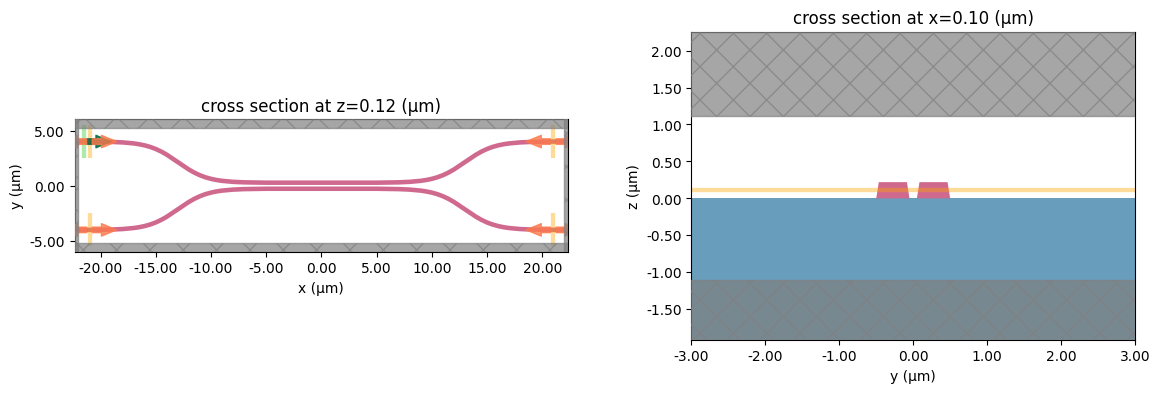

In [6]:
# Length of the coupling region
coup_length = 10

# Waveguide separation in the coupling region
wg_spacing_coup = 0.10

sim = make_sim(coup_length, wg_spacing_coup, add_field_monitor=True)

# Visualize geometry
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sim.plot(z=wg_height / 2 + 0.01, ax=ax1)
sim.plot(x=0.1, ax=ax2)
ax2.set_xlim([-3, 3])
plt.show()

## Design Space Exploration
In this section, we take advantage of the simplicity of the tidy3d design plugin to generate a Monte Carlo search over the geometric parameters of the coupler. The design plugin allows us to easily run optimizations that consider a set of user defined variables as optimization parameters. In this case, we leverage the plugin to generate a randomly sampled set of data that we can later use to train the neural network surrogate model. To do this, we set up the parameter names we are considering along with the ranges to sample values from for each. Then, we create a `MethodMonteCarlo` to specify the number of samples to evaluate and a `DesignSpace` to facilitate the running of the Monte Carlo method. Finally, we write a function, `fn_post` that will be used to postprocess the data from each from each simulation run. In this function, we use the above `measure_coupling_amplitude` function to collect the power flowing into all of the waveguide monitor ports. A tutorial on the design plugin can be found [here](https://www.flexcompute.com/tidy3d/examples/notebooks/Design/). 

In [7]:
# Set up the parameters we want to sweep in the Monte Carlo search
param_spc = tdd.ParameterFloat(name="wg_spacing_coup", span=wg_spacing_coup_range)
param_len = tdd.ParameterFloat(name="coup_length", span=coup_length_range)
parameters = [param_spc, param_len]

monte_carlo = tdd.MethodMonteCarlo(
    num_points=num_monte_carlo_sims,
    seed=2,
)
design_space = tdd.DesignSpace(
    method=monte_carlo,
    parameters=parameters,
    task_name="DC_MC_Surrogate",
    path_dir=str(mc_data_dir),
)


def measure_coupling_amplitude(sim_data):
    """Constructs a "row" of the scattering matrix when sourced from top left port"""

    input_amp = sim_data["in"].amps.sel(direction="+")

    amps_dict = {}
    directions = ("-", "-", "+", "+")
    for monitor, direction in zip(sim_data.simulation.monitors[:4], directions):
        amp = sim_data[monitor.name].amps.sel(direction=direction)
        amp_normalized = amp / input_amp
        amps_dict[monitor.name] = amp_normalized

    return amps_dict


def fn_post(*args, **kwargs):
    """Post processing function, but label the outputs using a dictionary."""
    amps_dict = measure_coupling_amplitude(*args, **kwargs)
    return amps_dict

Here, we run the Monte Carlo simulations or load previous simulation data from a past run through the notebook. If the simulations are run again, we overwrite the simulation data file to be loaded again in the future. By setting the `use_previous_simulation_data` flag, you can opt to use past data or rerun the simulations. If any of the parameters controlling the general geometry or number of simulations are changed, you should rerun the simulations to ensure they are accurate for the result of the notebook.

In [8]:
if use_previous_simulation_data:
    with open(filename_mc_data, "rb") as in_file:
        results = pickle.load(in_file)
        df = results.to_dataframe()
else:
    results = design_space.run(make_sim, fn_post, verbose=True)
    df = results.to_dataframe()

    with open(filename_mc_data, "wb") as out_file:
        pickle.dump(results, out_file)

20:00:27 CEST Running 100 Simulations

We can plot the fitness for each set of randomly sampled geometric parameters in the Monte Carlo batch of simulations. Better performing designs correspond to a larger fitness function with a maximum value of 0. In the plot, the points are colored according to their fitness value. The fitness function is the mean squared error between the desired output power fraction into each of the two waveguides and the actual output power fraction computed from the simulation results. In this example, we set the desired power fraction to 0.25/0.75 for top/bottom waveguides. However, this notebook can be re-run with a variety of different splitting ratios by changing the `top_waveguide_transmission_goal` and `bottom_waveguide_transmission_goal` parameters. We can see from this plot that several randomly selected points correspond to acceptable performances in our metric. The data collected in this first step will become the training data for a surrogate model of the coupling problem. We will use the surrogate model as an input to further optimization to see if we can discover even better designs than the ones we found via random sampling.

The best fitness value is -0.0004619891447938993 corresponding to:
MC Top waveguide transmission: 0.262, Bottom waveguide transmission: 0.732


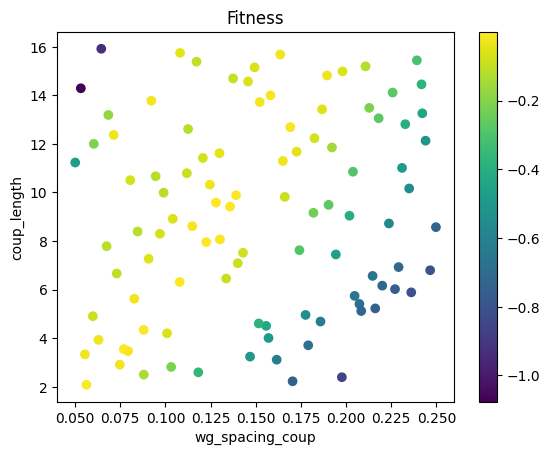

In [9]:
top_center_freq = abs(df["top"].apply(lambda x: x.sel(f=freq0, method="nearest"))) ** 2
bot_center_freq = abs(df["bottom"].apply(lambda x: x.sel(f=freq0, method="nearest"))) ** 2


# Compute MSE error function for fitness
def fitness(top_wg_power, bottom_wg_power):
    return -(
        abs(top_wg_power - top_waveguide_transmission_goal) ** 2
        + abs(bottom_wg_power - bottom_waveguide_transmission_goal) ** 2
    )


fitness_val = fitness(top_center_freq, bot_center_freq)
list_fitness = [float(np.squeeze(val.data)) for val in fitness_val]

best_fitness = np.max(fitness_val)
best_fitness_location = np.argmax(fitness_val)
best_top_power_mc = np.squeeze(top_center_freq[best_fitness_location].data)
best_bottom_power_mc = np.squeeze(bot_center_freq[best_fitness_location].data)
print(f"The best fitness value is {np.squeeze(best_fitness.data)} corresponding to:")
print(
    f"MC Top waveguide transmission: {np.round(best_top_power_mc, 3)}, Bottom waveguide transmission: {np.round(best_bottom_power_mc, 3)}"
)

scatter = plt.scatter(df["wg_spacing_coup"], df["coup_length"], c=list_fitness)
plt.xlabel("wg_spacing_coup")
plt.ylabel("coup_length")
plt.title("Fitness")
plt.colorbar(scatter)
plt.show()

## Neural Network Surrogate Model

We can now leverage the Monte Carlos data we collected from tidy3d simulation. First, we clean and prepare the dataset for use in training a neural network surrogate model. The inputs to the model are the waveguide spacing (`wg_spacing_coup`), the coupling length (`coup_length`), and the frequency (`freq`). In optimizing the model, we aim to find the connection between these inputs and the output power fractions in the top and bottom waveguides (`top` and `bottom`).

In [10]:
expanded_df = df.copy()
# Removing the input and reflection amplitudes because we will run the
# neural network optimization only over the output waveguide amplitudes
# and thus assume reflected power is negligible.
expanded_df.drop("in", axis=1, inplace=True)
expanded_df.drop("reflect_bottom", axis=1, inplace=True)

# Expand out multiple entries for top and bottom and re-index the dataframe.
# then, we can add the frequency dimension to the dataframe.
expanded_df = expanded_df.explode(["top", "bottom"]).reset_index(drop=True)
expanded_df["freq"] = expanded_df["top"].apply(lambda x: float(x.f))

# Convert the amplitude fractions into power fractions for the top and bottom waveguides.
expanded_df["top"] = expanded_df["top"].apply(lambda x: float(abs(x) ** 2))
expanded_df["bottom"] = expanded_df["bottom"].apply(lambda x: float(abs(x) ** 2))

# Visualize the dataframe
print("Monte Carlo data for training the neural network surrogate model")
print(expanded_df[["wg_spacing_coup", "coup_length", "freq", "top", "bottom"]])

# Read the dataframe back into a Result that we can use as a pytorch Dataset
expanded_results = tdd.Result()
expanded_results = expanded_results.from_dataframe(expanded_df, dims=list(results.dims) + ["freq"])

Monte Carlo data for training the neural network surrogate model
       wg_spacing_coup  coup_length          freq       top    bottom
0             0.137477    14.698211  1.998616e+14  0.223059  0.771090
1             0.137477    14.698211  1.997285e+14  0.218406  0.775767
2             0.137477    14.698211  1.995955e+14  0.213763  0.780423
3             0.137477    14.698211  1.994627e+14  0.209135  0.785061
4             0.137477    14.698211  1.993301e+14  0.204506  0.789673
...                ...          ...           ...       ...       ...
10095         0.055433     3.331761  1.878399e+14  0.014354  0.979565
10096         0.055433     3.331761  1.877223e+14  0.012926  0.981028
10097         0.055433     3.331761  1.876048e+14  0.011567  0.982425
10098         0.055433     3.331761  1.874875e+14  0.010278  0.983722
10099         0.055433     3.331761  1.873703e+14  0.009060  0.984942

[10100 rows x 5 columns]


We can use the `Result` class directly as a pytorch dataset and take advantage of pytorch utilities to create a training, validation, and testing split of the data. Documentation on handling data in pytorch can be found [here](https://pytorch.org/docs/stable/data.html). The training data we will use directly to adjust network weights. Validation data is used to assess the quality of the model when applied to non-training data. It is a useful evaluation criteria when deciding between different network hyperparameters. We reserve testing data for the end to perform a final verification on the trained model.

In [11]:
# Neural Network parameters
number_samples = len(expanded_results)
train_samples = int(np.floor(0.6 * number_samples))
validation_samples = int(np.floor(0.2 * number_samples))
test_samples = number_samples - train_samples - validation_samples
batch_size = 16
epochs = 120
final_training_epochs = 1000

training_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(
    expanded_results, [train_samples, validation_samples, test_samples]
)

training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
testing_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In this section, we set up the general structure for a fully connected neural network with a variable number of hidden layers, ReLU activation functions, and the option to include dropout layers to prevent overfitting and improve generalization. The input to the network is given by two geometric parameters and the frequency, the three of which are normalized to fall between [-1, 1] based on their allowed ranges. The output of the network is the power fraction in the top and bottom waveguides. More information on how to build neural networks in pytorch can be found [here](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html).

In [12]:
# Assuming the features are coming in as (wg_spacing_coup, coup_length, freq)
# and we can normalize by the min/max possible values to center each feature in [-1, 1]
min_freq = np.min(freqs)
max_freq = np.max(freqs)

subtract_min = torch.tensor(
    [wg_spacing_coup_range[0], coup_length_range[0], min_freq], dtype=torch.float
)
normalize_max = torch.tensor(
    [
        wg_spacing_coup_range[1] - wg_spacing_coup_range[0],
        coup_length_range[1] - coup_length_range[0],
        max_freq - min_freq,
    ],
    dtype=torch.float,
)

network_input_size = 3


# Define a fully connected model in PyTorch with ReLU activation
# where we can set a variable number of hidden layers through
# neurons list. Allow option to specify dropout percentage.
class VariableANN(nn.Module):
    def __init__(self, input_size, neurons, dropout) -> None:
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, neurons[0]))

        for i in range(1, len(neurons)):
            self.layers.append(nn.Linear(neurons[i - 1], neurons[i]))

        self.layers.append(nn.Linear(neurons[-1], 2))

        self.drop = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        subtract_min_unsqueeze = torch.unsqueeze(subtract_min, dim=0)
        normalize_max_unsqueeze = torch.unsqueeze(normalize_max, dim=0)

        # normalize inputs to be between [-1, 1]
        x = x - subtract_min_unsqueeze
        x = x / normalize_max_unsqueeze
        x = 2.0 * (x - 0.5)

        for layer in self.layers[:-1]:
            x = self.drop(self.relu(layer(x)))

        x = self.layers[-1](x)

        return x

We set up functions here to facilitate the training of the neural network. By default, we use an MSE loss function in the training that computes the mean squared error between the network's output power fractions and the ground truth output power fractions. In each epoch of training, we run through all the batches in the training dataset, adjusting the weights in the network with an Adam optimizer after each batch. We also keep track of the validation loss from when the network is in evaluation mode and processing data from the validation dataset. This will be useful later for choosing the best network hyperparameters. More information on how to train neural networks in pytorch can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html).

In [13]:
loss_fn = nn.MSELoss()


def evaluate_loss(data, network, loss_fn_user=None):
    """Extract inputs/labels from the data and allow for loss evaluation on user defined loss
    function (otherwise use the default loss_fn which is set to MSE)."""

    inputs, labels = data

    if loss_fn_user is None:
        loss_fn_user = loss_fn

    loss = loss_fn_user(network(inputs.type(torch.FloatTensor)), labels.type(torch.FloatTensor))

    return loss


def evaluate_loss_from_loader(data_loader, network, loss_fn_user=None):
    """Given a data_loader, run all the batches through the network and evaluate loss."""
    loss_by_iteration = []
    for data_idx, data in enumerate(data_loader):
        loss = evaluate_loss(data, network, loss_fn_user)
        loss_by_iteration.append(loss.item())

    avg_loss = np.mean(loss_by_iteration)
    return avg_loss


def train_network(hyperparameters, epochs):
    """Train a network according to hyperparameters specification for a given number of epochs."""

    # build network and set to training mode
    network = VariableANN(network_input_size, hyperparameters["hidden"], hyperparameters["dropout"])
    network.train()
    opt = optim.Adam(
        network.parameters(),
        lr=hyperparameters["learning_rate"],
        weight_decay=hyperparameters["weight_decay"],
    )

    training_loss_by_epoch = np.zeros(1 + epochs)
    validation_loss_by_epoch = np.zeros(1 + epochs)

    avg_training_loss = evaluate_loss_from_loader(training_dataloader, network)
    avg_validation_loss = evaluate_loss_from_loader(validation_dataloader, network)

    training_loss_by_epoch[0] = avg_training_loss
    validation_loss_by_epoch[0] = avg_validation_loss

    for epoch_idx in range(0, epochs):
        training_loss_by_iteration = []

        for data_idx, data in enumerate(training_dataloader):
            opt.zero_grad()
            loss = evaluate_loss(data, network)

            training_loss_by_iteration.append(loss.item())

            loss.backward()
            opt.step()

        # Remove training features like dropout for the evaluation section and then turn it back on for training
        network.eval()
        avg_validation_loss = evaluate_loss_from_loader(validation_dataloader, network)
        network.train()

        training_loss_by_epoch[1 + epoch_idx] = np.mean(training_loss_by_iteration)
        validation_loss_by_epoch[1 + epoch_idx] = avg_validation_loss

    return training_loss_by_epoch, validation_loss_by_epoch, network

Next, we perform a random search over the network and optimizer hyperparameters to find the best structure and optimization. The figure of merit for the search is the validation error for the trained model because we ultimately care both about good network performance and its ability to generalize outside the training set. This search is done by randomly sampling hidden layer dimensions, number of hidden layers, and dropout percentage for the network and the learning rate and weight decay for the Adam optimizer. In this search, we fix the network to two hidden layers and train 75 trial network and optimization parameter combinations searching for the best validation loss. The tidy3d design plugin once again is useful here as we can utilize the Monte Carlo method once again to randomly choose parameters to evaluate.

In [14]:
allowed_hidden_layer_sizes = np.arange(16, 257, 16)
allowed_dropout = np.arange(0, 0.55, 0.05)
num_hidden_layers = 2
allowed_learning_rate_log_range = (-5, -3)
allowed_weight_decay_log_range = (-5, -4)

num_trial_networks = 75


def hyperparemeter_fn(dropout, learning_rate_log, weight_decay_log, **hidden_layer_sizes):
    hidden_layer_sizes = [
        hidden_layer_sizes[f"hidden_layer_size_{idx}"] for idx in range(0, len(hidden_layer_sizes))
    ]

    hyperparam = {
        "hidden": hidden_layer_sizes,
        "dropout": dropout,
        "learning_rate": 10**learning_rate_log,
        "weight_decay": 10**weight_decay_log,
    }

    training_loss, validation_loss, network = train_network(hyperparam, epochs)

    return -validation_loss[-1]


param_dropout = tdd.ParameterAny(name="dropout", allowed_values=tuple(allowed_dropout))
param_lr_log = tdd.ParameterFloat(name="learning_rate_log", span=allowed_learning_rate_log_range)
param_wd_log = tdd.ParameterFloat(name="weight_decay_log", span=allowed_weight_decay_log_range)
params_hyperparameter = [
    tdd.ParameterAny(
        name=f"hidden_layer_size_{idx}",
        allowed_values=tuple(allowed_hidden_layer_sizes),
    )
    for idx in range(0, num_hidden_layers)
]
hyperparameters = [param_dropout, param_lr_log, param_wd_log] + params_hyperparameter

hyperparam_optimizer = tdd.MethodMonteCarlo(
    num_points=num_trial_networks,
    seed=2,
)
design_space = tdd.DesignSpace(
    method=hyperparam_optimizer,
    parameters=hyperparameters,
    task_name="DC_Network_MC",
    path_dir=str(mc_data_dir),
)
network_hyperparameter_results = design_space.run(hyperparemeter_fn, verbose=True)

After the hyperparameter search, we perform one final network training using the best hyperparameter settings and an increased number of training epochs. This network can now operate as the surrogate solver for the coupling problem.

Best network hyperparameters:
hidden : [144, 160]
dropout : 0.0
learning_rate : 0.0005177283857996054
weight_decay : 1.4211205011036916e-05

Average training loss: 2.111494920924246e-05
Average validation loss: 2.4598028360520316e-05
Average test loss: 2.1038408199166852e-05
Average L1 validation loss: 0.0028564875595286253
Average L1 test loss: 0.0027615668620606226


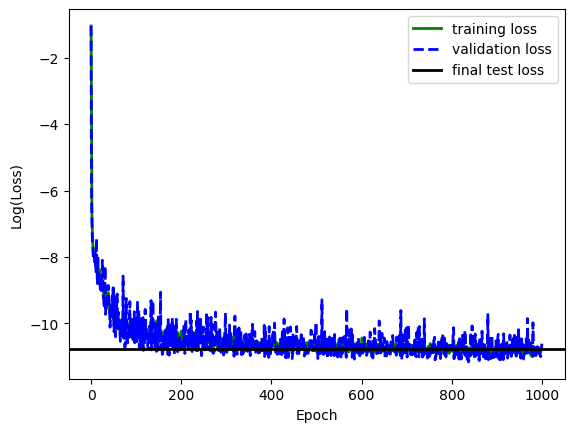

In [15]:
# Extract the best parameters from the design space result and formulate the hyperparameter dictionary for the optimization
best_parameters = dict(
    zip(
        network_hyperparameter_results.dims,
        network_hyperparameter_results.coords[np.argmax(network_hyperparameter_results.values)],
    )
)
best_hyperparam = {
    "hidden": [best_parameters[f"hidden_layer_size_{idx}"] for idx in range(0, num_hidden_layers)],
    "dropout": best_parameters["dropout"],
    "learning_rate": 10 ** best_parameters["learning_rate_log"],
    "weight_decay": 10 ** best_parameters["weight_decay_log"],
}
print("Best network hyperparameters:")
for k, v in best_hyperparam.items():
    print(f"{k} : {v}")
avg_training_loss, avg_validation_loss, optimized_network = train_network(
    best_hyperparam, final_training_epochs
)
optimized_network.eval()

# Report the final average training loss from the final optimization as well as the validation and test losses for eval mode
avg_test_loss = evaluate_loss_from_loader(testing_dataloader, optimized_network)
print(f"\nAverage training loss: {avg_training_loss[-1]}")
print(f"Average validation loss: {avg_validation_loss[-1]}")
print(f"Average test loss: {avg_test_loss}")

# Compute the L1 validation and test loss in eval mode to get a better intuitive sense of the network performance by examining
# absolute error instead of squared error
l1_loss_fn = nn.L1Loss()
avg_l1_validation_loss = evaluate_loss_from_loader(
    validation_dataloader, optimized_network, l1_loss_fn
)
avg_l1_test_loss = evaluate_loss_from_loader(testing_dataloader, optimized_network, l1_loss_fn)

print(f"Average L1 validation loss: {avg_l1_validation_loss}")
print(f"Average L1 test loss: {avg_l1_test_loss}")

# Plot log of loss curves for the network
plt.plot(
    np.arange(0, len(avg_training_loss)),
    np.log(avg_training_loss),
    color="g",
    linewidth=2,
    label="training loss",
)
plt.plot(
    np.arange(0, len(avg_validation_loss)),
    np.log(avg_validation_loss),
    color="b",
    linewidth=2,
    label="validation loss",
    linestyle="--",
)
plt.axhline(y=np.log(avg_test_loss), color="k", linewidth=2, label="final test loss")
plt.xlabel("Epoch")
plt.ylabel("Log(Loss)")
plt.legend()
plt.show()

## DC Optimization

The final optimization step uses the neural network surrogate as part of a gradient based optimization. Instead of running simulations for each candidate set of geometric parameters, we use the neural network to estimate the output waveguide power fractions. We set as a loss function the mean squared error between the output of the network and our desired splitting ratio of 0.25/0.75. However, instead of optimizing the network weights as we did before, we optimize the network input (i.e. - the coupling geometric parameters) to reduce the loss. Below, we see this converges quickly and identifies a good set of parameters for the coupler.

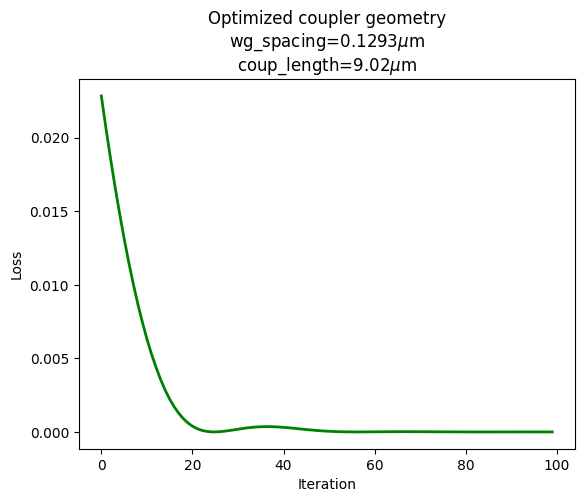

In [16]:
# Set up coupler geometry in a pytorch tensor and initialize to the mean values
# for both the coupling length and the waveguide spacing
coupler_geometry = torch.Tensor([np.mean(wg_spacing_coup_range), np.mean(coup_length_range)])
coupler_geometry.requires_grad = True  # we will track the gradient in the optimizer

freq_tensor = torch.Tensor([freq0]).unsqueeze(dim=0)  # design coupler at center frequency

# Set up bounds to clamp the design parameters between so we stay in the parameter
# space learned by the neural network surrogate
min_design_tensor = torch.Tensor([np.min(wg_spacing_coup_range), np.min(coup_length_range)])
max_design_tensor = torch.Tensor([np.max(wg_spacing_coup_range), np.max(coup_length_range)])

# Set up the transmission goal we can use in the loss function and define an MSE loss
desired_transmission = torch.Tensor(
    [top_waveguide_transmission_goal, bottom_waveguide_transmission_goal]
)
mse_loss = nn.MSELoss()

# Create an Adam optimizer the focuses on optimizing the coupler geometry
# based on the surrogate prediction
opt = optim.Adam(
    [coupler_geometry],
    lr=1e-3,
    weight_decay=1e-5,
)

coupler_optimization_iterations = 100
coupler_loss_curve = np.zeros(coupler_optimization_iterations)

for idx in range(0, coupler_optimization_iterations):
    opt.zero_grad()

    # Clamp the geometry between the min/max values allowed
    clamp_geometry = torch.clamp(coupler_geometry, min_design_tensor, max_design_tensor)

    # Combine the geometry parameters with the frequency
    geometry_and_freq = torch.cat((clamp_geometry.unsqueeze(dim=0), freq_tensor), dim=1)

    # Check the surrogate's prediction for the current coupler geometry
    prediction = torch.squeeze(optimized_network(geometry_and_freq))

    # Compute the loss based on the goal transmission in each waveguide
    loss = mse_loss(prediction, desired_transmission)
    coupler_loss_curve[idx] = loss.item()

    loss.backward()  # backpropagate
    opt.step()  # step parameters


final_geometry = torch.clamp(coupler_geometry, min_design_tensor, max_design_tensor)
final_geometry_numpy = final_geometry.detach().numpy()
final_geometry_numpy_display = [float(np.round(float(num), 4)) for num in final_geometry_numpy]

plt.plot(coupler_loss_curve, linewidth=2, color="g")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title(
    "Optimized coupler geometry\n"
    rf"wg_spacing={final_geometry_numpy_display[0]}$\mu$m"
    "\n"
    rf"coup_length={final_geometry_numpy_display[1]}$\mu$m"
)
plt.show()

Using the parameters from our optimization, we run a final electromagnetic evaluation of the coupler. This allows us to assess one more time the quality of the surrogate model as well as evaluate the performance of the final design.

In [17]:
optimized_coup_length = final_geometry_numpy[1]
optimized_wg_spacing = final_geometry_numpy[0]
sim = make_sim(optimized_coup_length, optimized_wg_spacing)
sim_data = web.run(sim, task_name="best_predicted")

20:43:07 CEST Created task 'best_predicted' with task_id                        
              'fdve-3017a068-b145-4777-95f9-5d0e7a647a53' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=336054;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3017a068-b145-4777-95f9-5d0e7a647a53\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=286107;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3017a068-b145-4777-95f9-5d0e7a647a53\taskId]8;;\]8;id=336054;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3017a068-b145-4777-95f9-5d0e7a647a53\=]8;;\]8;id=457499;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3017a068-b145-4777-95f9-5d0e7a647a53\fdve]8;;\]8;id=336054;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3017a068-b145-4777-95f9-5d0e7a647a53\-3017a068-b1]8;;\
              ]8;id=336054;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3017a068-b145-4777-95f9-5d0e7a647a53\45-4777-95f9-5d0e7a647a53']8;;\.

              Task folder: ]8;id=792309;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

20:43:09 CEST Maximum FlexCredit cost: 0.629. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

20:43:10 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

20:43:15 CEST status = preprocess

20:43:19 CEST starting up solver

              running solver

Output()

20:43:49 CEST early shutoff detected at 48%, exiting.

              status = postprocess

Output()

20:43:53 CEST status = success

20:43:55 CEST View simulation result at                                         
              ]8;id=251136;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3017a068-b145-4777-95f9-5d0e7a647a53\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=675776;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3017a068-b145-4777-95f9-5d0e7a647a53\taskId]8;;\]8;id=251136;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3017a068-b145-4777-95f9-5d0e7a647a53\=]8;;\]8;id=902314;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3017a068-b145-4777-95f9-5d0e7a647a53\fdve]8;;\]8;id=251136;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3017a068-b145-4777-95f9-5d0e7a647a53\-3017a068-b1]8;;\
              ]8;id=251136;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3017a068-b145-4777-95f9-5d0e7a647a53\45-4777-95f9-5d0e7a647a53']8;;\.

Output()

20:43:57 CEST loading simulation from simulation_data.hdf5

For the optimal point, we report the power in both the top and bottom waveguides after the coupling. We can compare these powers to the best ones we found with Monte Carlo sampling of the coupler geometric parameters. They are improved, albeit not by a significant margin because the random sampler did a good job of finding adequate design parameters. For a low dimensional optimization problem like this, it is not entirely unexpected for this to be the case. However, this technique may improve in utility as the number of design parameters grows.

In [18]:
def make_prediction(network, wg_spacing_coup, coup_length, freq):
    """Use the neural network surrogate to estimate the output coupling power fractions."""
    feature_array = np.expand_dims(np.array([wg_spacing_coup, coup_length, freq]), axis=0)
    input_tensor = torch.Tensor(feature_array)
    prediction = np.squeeze(network(input_tensor).detach().numpy())

    return prediction


# Extract power in each waveguide from simulation data
amps_dict = measure_coupling_amplitude(sim_data)
print(
    f"Top simulated waveguide transmission: {np.round(float(abs(amps_dict['top'].sel({'f': freq0})) ** 2), 5)}, Bottom simulated waveguide transmission: {np.round(float(abs(amps_dict['bottom'].sel({'f': freq0})) ** 2), 5)}\n"
)

# Check the network prediction for this point to compare
feature_array = np.array(
    (
        optimized_wg_spacing,
        optimized_coup_length,
        freq0,
    )
)

prediction = make_prediction(optimized_network, *feature_array)
print("Compare these values to the predicted values from the surrogate model:")
print(
    f"Top predicted waveguide transmission: {np.round(float(prediction[0]), 5)}, Bottom predicted waveguide transmission: {np.round(float(prediction[1]), 5)}\n"
)

# Compare the result above to the best point found via Monte Carlo sampling where geometric parameters were chosen at random
print("Compare these values to the ones found via Monte Carlo sampling:")
print(
    f"Top simulated MC waveguide transmission: {np.round(best_top_power_mc, 5)}, Bottom simulated MC waveguide transmission: {np.round(best_bottom_power_mc, 5)}"
)

Top simulated waveguide transmission: 0.24442, Bottom simulated waveguide transmission: 0.74861

Compare these values to the predicted values from the surrogate model:
Top predicted waveguide transmission: 0.24604, Bottom predicted waveguide transmission: 0.7475

Compare these values to the ones found via Monte Carlo sampling:
Top simulated MC waveguide transmission: 0.26192, Bottom simulated MC waveguide transmission: 0.73212


Since the neural network was trained to predict output powers for multiple frequencies, we can compare the spectrum prediction for our final design to the ground truth simulation data. We also summarize the mean squared and mean absolute error across the spectrum.

Error summary for optimal point:
MSE for top: 5.756458536304202e-06
MSE for bottom: 4.2418515470648096e-06
MAE for top: 0.0018401715521854354
MAE for bottom: 0.0015413127160672296


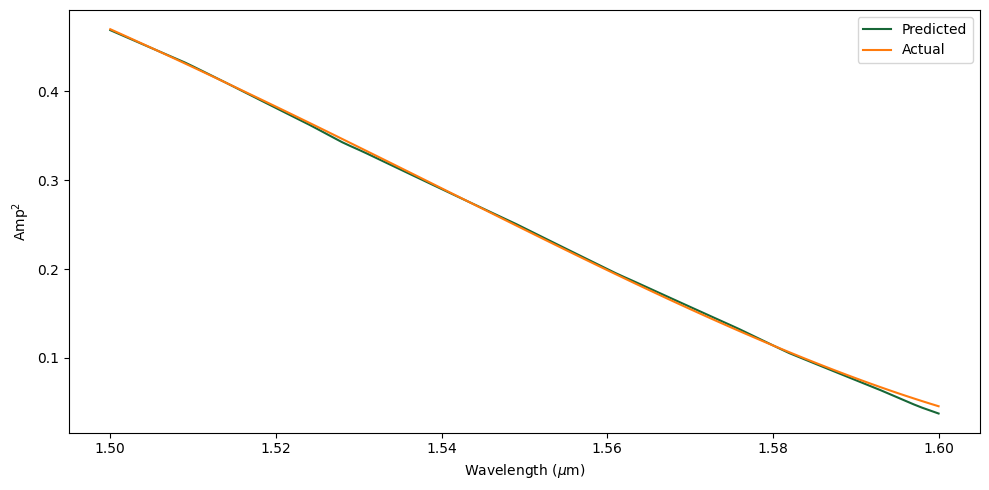

In [19]:
top_amp_predict = np.zeros(len(freqs))
top_amp_real = np.zeros(len(freqs))
bot_amp_predict = np.zeros(len(freqs))
bot_amp_real = np.zeros(len(freqs))

for idx, freq_val in enumerate(freqs):
    feature_array = np.array(
        (
            optimized_wg_spacing,
            optimized_coup_length,
            freq_val,
        )
    )

    prediction = make_prediction(optimized_network, *feature_array)

    top_amp_predict[idx] = prediction[0]
    top_amp_real[idx] = float(abs(amps_dict["top"].sel({"f": freq_val})) ** 2)

    bot_amp_predict[idx] = prediction[1]
    bot_amp_real[idx] = float(abs(amps_dict["bottom"].sel({"f": freq_val})) ** 2)

fig, ax = plt.subplots(1, tight_layout=True, figsize=(10, 5))


mse_top = np.mean((top_amp_predict - top_amp_real) ** 2)
mse_bottom = np.mean((bot_amp_predict - bot_amp_real) ** 2)
mae_top = np.mean(np.abs(top_amp_predict - top_amp_real))
mae_bottom = np.mean(np.abs(bot_amp_predict - bot_amp_real))

print("Error summary for optimal point:")
print(f"MSE for top: {mse_top}")
print(f"MSE for bottom: {mse_bottom}")
print(f"MAE for top: {mae_top}")
print(f"MAE for bottom: {mae_bottom}")

ax.plot(td.C_0 / freqs, top_amp_predict, label="Predicted")
ax.plot(td.C_0 / freqs, top_amp_real, label="Actual")
ax.set_xlabel(r"Wavelength ($\mu$m)")
ax.set_ylabel("Amp$^2$")
plt.legend()
plt.show()